In [1]:
from google.colab import auth

auth.authenticate_user()

In [2]:
%%bash
pip3 install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199674 sha256=309dbb3eb9ce50d22a88fc78d4573385e4788293c88aa16dccce26c67e965747
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [43]:
import numpy as np
import pandas as pd
import sklearn
import fasttext
from sklearn import metrics
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [4]:
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"

Copying gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt...
/ [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     
Copying gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt...

Operation completed over 1 objects/91.6 MiB.                                     


In [5]:
# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = "__label__positive"
dataset_neg_pd['label'] = "__label__negative"
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

<ipython-input-5-d0d7145b8249>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
<ipython-input-5-d0d7145b8249>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])


In [6]:
N = len(dataset_pd)
val_data_size = int(0.1 * len(dataset_pd.index))
test_data_size = int(0.1 * len(dataset_pd.index))

dataset_train = dataset_pd[:N - val_data_size - test_data_size]
dataset_test = dataset_pd[N - test_data_size:]

# fasttext
np.savetxt(r'data.train.txt', dataset_train.values, fmt='%s')
np.savetxt(r'data.test.txt', dataset_test.values, fmt='%s')

In [8]:
model = fasttext.train_supervised('data.train.txt')

# Evaluate Model

In [42]:
_, accuracy, _ = model.test('data.test.txt')
print("Accuracy = {:.4f}".format(accuracy))

Accuracy = 0.8283


ACE = 0.0079, MCE = 0.0175


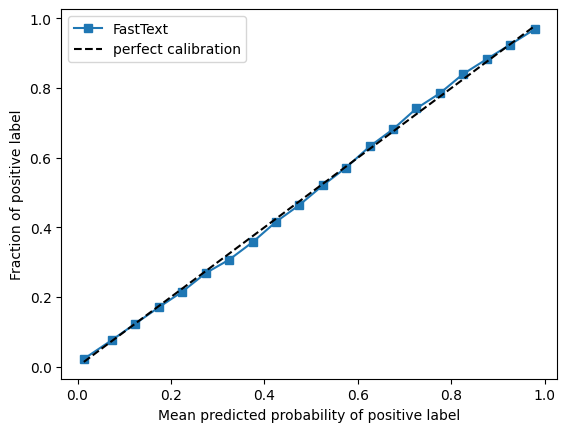

In [71]:
preds = model.predict(dataset_test["text"].tolist())
probs = np.array([p[0] if l[0]=='__label__positive' else 1-p[0] for l, p in zip(preds[0], preds[1])])
probs = np.minimum(np.maximum(probs, 0), 1)

labels = np.array(dataset_test["label"] == '__label__positive', dtype=int)

nbins = 20

# compute adaptive calibration error (ace)
prob_true_quantile, prob_pred_quantile = calibration_curve(y_true=labels, y_prob=probs,
                                                            n_bins=nbins, strategy='quantile')
ace = np.mean(np.abs(prob_true_quantile - prob_pred_quantile))

# compute maximum calibration error (mce)
prob_true, prob_pred = calibration_curve(y_true=labels, y_prob=probs,
                                          n_bins=nbins, strategy='uniform')
mce = np.max(np.abs(prob_true - prob_pred))

print("ACE = {:.4f}, MCE = {:.4f}".format(ace, mce))

# calibration curve
plt.plot(prob_pred, prob_true, label="FastText", marker='s')
plt.plot(prob_pred, prob_pred, label="perfect calibration", linestyle='--', color='black')
plt.xlabel("Mean predicted probability of positive label")
plt.ylabel("Fraction of positive label")
plt.legend()
plt.show()
